In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
def pre_triplet(labels):
    data = {}
    for i in range(len(labels)):
        d = {}
        d["N"] = [j for j in range(len(labels)) if (i != j) and (labels[i] != labels[j])]
        d["P"] = [j for j in range(len(labels)) if (i != j) and (labels[i] == labels[j])]
        
        data[i] = d

    return data

pre_triplet( ["A", "A", "B", "B"] )

{0: {'N': [2, 3], 'P': [1]},
 1: {'N': [2, 3], 'P': [0]},
 2: {'N': [0, 1], 'P': [3]},
 3: {'N': [0, 1], 'P': [2]}}

In [4]:
toTensor = transforms.ToTensor()

sample_size = 20
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xTensor.shape

torch.Size([200, 1, 28, 28])

In [5]:
APN = pre_triplet( ySub )
APN_combos = [ [[(a,p,n) for p in APN[a]["P"] ] for n in APN[a]["N"]] for a in APN]

APN_combos = [item for row in [item for row in APN_combos for item in row] for item in row] # Flatten APN_combos

apnLen = len( APN_combos )
apnLen

724392

In [6]:
random.randint(0,5)

5

In [7]:
model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=32
                                 )
optimizer = optim.SGD( model.parameters() )

for i in range(3000):
    results = model(xTensor)

    # === make anchor, positive, negeative lists ===
    a_list = []
    p_list = []
    n_list = []

    random.shuffle(APN_combos) # Den her del er rigtig dyr når der er meget data

    for apn in APN_combos[APN_combos]:
        a_list.append(results[ apn[0] ])
        p_list.append(results[ apn[1] ])
        n_list.append(results[ apn[2] ])
    
    # === Improve Model ===
    optimizer.zero_grad()

    loss = criterion(torch.stack(a_list),
                     torch.stack(p_list),
                     torch.stack(n_list) )
    
    loss.backward()
    optimizer.step()

    print(i, loss)

0 tensor(32.0033, grad_fn=<MeanBackward0>)
1 tensor(31.9997, grad_fn=<MeanBackward0>)
2 tensor(32.0013, grad_fn=<MeanBackward0>)
3 tensor(31.9986, grad_fn=<MeanBackward0>)
4 tensor(32.0002, grad_fn=<MeanBackward0>)
5 tensor(32.0023, grad_fn=<MeanBackward0>)
6 tensor(32.0003, grad_fn=<MeanBackward0>)
7 tensor(32.0001, grad_fn=<MeanBackward0>)
8 tensor(31.9974, grad_fn=<MeanBackward0>)
9 tensor(31.9989, grad_fn=<MeanBackward0>)
10 tensor(32.0062, grad_fn=<MeanBackward0>)
11 tensor(31.9993, grad_fn=<MeanBackward0>)
12 tensor(31.9959, grad_fn=<MeanBackward0>)
13 tensor(31.9961, grad_fn=<MeanBackward0>)
14 tensor(32.0016, grad_fn=<MeanBackward0>)
15 tensor(32.0058, grad_fn=<MeanBackward0>)
16 tensor(32.0029, grad_fn=<MeanBackward0>)
17 tensor(31.9998, grad_fn=<MeanBackward0>)
18 tensor(32.0003, grad_fn=<MeanBackward0>)
19 tensor(31.9989, grad_fn=<MeanBackward0>)
20 tensor(32.0035, grad_fn=<MeanBackward0>)
21 tensor(31.9988, grad_fn=<MeanBackward0>)
22 tensor(32.0028, grad_fn=<MeanBackward0>

20 obs, 50/570 samples, 3k ittr  --> 11s

20 obs, 250/570 samples, 3k ittr --> 30s

20 obs, 570/570 samples, 3k ittr --> 57s

# Viz

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

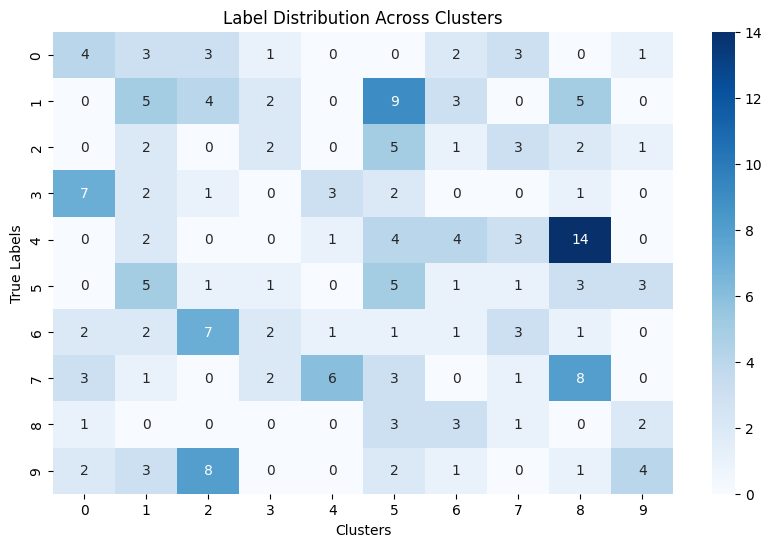

In [9]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [10]:
model(xTensor).detach().numpy()

array([[0.48712036, 0.48391408, 0.4907963 , ..., 0.4924093 , 0.5145453 ,
        0.49265188],
       [0.4977965 , 0.48610568, 0.49739474, ..., 0.48164895, 0.5164954 ,
        0.5003714 ],
       [0.482746  , 0.48759806, 0.48242402, ..., 0.48835143, 0.5200263 ,
        0.50774574],
       ...,
       [0.49296048, 0.48979688, 0.4859839 , ..., 0.48137212, 0.5206247 ,
        0.5126109 ],
       [0.4921873 , 0.48288584, 0.47526404, ..., 0.4860993 , 0.5187322 ,
        0.5134585 ],
       [0.49606898, 0.48178205, 0.48527706, ..., 0.48924407, 0.5164852 ,
        0.51320827]], dtype=float32)

In [12]:
True * True

1